In diesem Projekt wollen wir aus dem Air Passenger Dataset eine Vorhersage der zukuenftigen Passagiere machen. Dazu importieren wir uns das DataSet aus statsmodels, fuehren einige Data Pre Processing Funktionen durch und splitten unseren Datensatz in ein Trainings- und einen Validierungsdatensatz.  
Wir benutzen fuer unsere Operationen jedoch nicht die Standardmaessigen Libraries wie PANDAS oder sklearn, sondern wir wollen unser ARIMA Model auf der GPU trainieren, statt wie ueblich mit Hilfe der CPU. Dazu importieren wir die CuDF und CuML Library (eine Analyse und eine naehere Ausarbeitung findet sich unter auch auf dieser Website unter diesem [Link](https://hemniels.github.io/ml_notebooks/rndF-cuML_vs_SciKit.html)).  
Wir benutzen hierzu den ebenfalls GPU faehigen scaler der CuML Library um unsere Datensaetze an das ARIMA Model anzupassen. Unter dem oben angegebenen Link finden sich auch naehre Details zu meinem verwendeten Setup.  
Am Ende plotten wir ganz normal unsere Ergebnisse und sind gespannt ob unser ARIMA Model eine Vorhersage geben kann, wie viele Passagiere zu erwarten sind. Ausserdem werden die Zeitangaben zur Geschwindigkeit der GPU ausgegeben.

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import cudf
import statsmodels.api as sm
import time
import cuml
import warnings
warnings.filterwarnings('ignore')

from cuml.tsa.arima import ARIMA

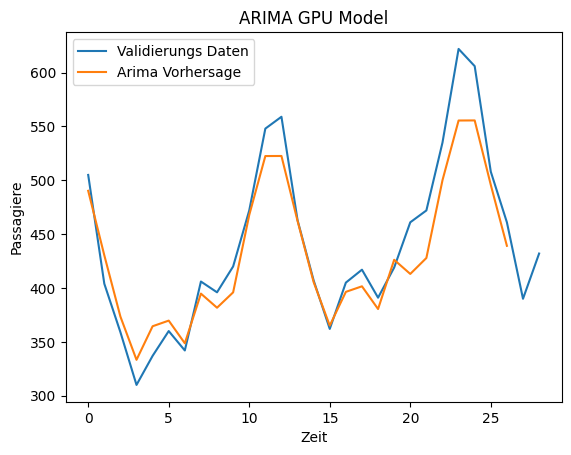

Zeit fuer model.fit GPU: 7.5827 Sekunden
Zeit fuer predictions GPU: 0.0038 Sekunden
Zeit fuer den GPU Scaler, Training UND Val: 0.0040 Sekunden


In [62]:
#Lade das Dataset
data = sm.datasets.get_rdataset('AirPassengers', 'datasets').data

#Konvertierung zu GPU DataFrame + Data Pre Processing
gpu_df         = cudf.DataFrame.from_pandas(data)
gpu_df['time'] = cudf.to_datetime(gpu_df['time'])
gpu_df         = gpu_df.rename(columns={'time': 'Month'})
gpu_df         = gpu_df.rename(columns={'value': 'AirPassengers'})
gpu_df         = gpu_df.set_index('Month')

# Erstelle Training / Validierung DataSet aus GPU DataFrame
train_size       = int(len(gpu_df) * 0.8)
train_df, val_df = gpu_df[:train_size], gpu_df[train_size:]

# Skalierung der Daten + Stoppuhr
scaler       = cuml.preprocessing.MinMaxScaler(feature_range=(0,1))
start_time   = time.time()
train_x      = scaler.fit_transform(np.array(train_df['AirPassengers'].to_arrow().to_pylist()).reshape(-1, 1)).ravel()
val_x        = scaler.transform(np.array(val_df['AirPassengers'].to_arrow().to_pylist()).reshape(-1, 1)).ravel()
scaler_speed = time.time() - start_time

# ARIMA MODEL + fit, predictions + Stoppuhr zur GPU-Geschwindigkeit
arima       = ARIMA(train_x, order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))
start_time  = time.time()
arima.fit()
fit_speed   = time.time() - start_time

start_time        = time.time()
predictions       = arima.forecast(27)
predictions_speed = time.time() - start_time

# Ergebnisplot + Rueckaengigmachung der Skalierung fuer bessere Visualisierung
predictions_unscaled = scaler.inverse_transform(predictions.reshape(-1, 1))
val_x_unscaled       = scaler.inverse_transform(val_x.reshape(-1, 1))

plt.plot(val_x_unscaled, label='Validierungs Daten')
plt.plot(predictions_unscaled, label='Arima Vorhersage')

plt.title('ARIMA GPU Model')
plt.xlabel('Zeit')
plt.ylabel('Passagiere')

plt.legend()
plt.show()

print(f"Zeit fuer model.fit GPU: {fit_speed:.4f} Sekunden")
print(f"Zeit fuer predictions GPU: {predictions_speed:.4f} Sekunden")
print(f"Zeit fuer den GPU Scaler, Training UND Val: {scaler_speed:.4f} Sekunden")

Wie wir sehen ist die Vorhersage von unserem ARIMA GPU Model fast gleich zu dem was die Validierungs Daten hergeben. Auf der Y-Achse sehen wir die Passagiere, auf der X-Achse die voranschreitende Zeit in 0-25 Schritten in die Zukunft.  
Fazit: Mit einem ARIMA Model das auf der GPU trainiert wurde, lassen sich die Passagierzahlen des Validierungsdatensatzes fast genau vorhersagen. 
Ausserdem sind die erreichten Geschwindigkeiten respektive des Datensatzes ausgezeichnet wie die Ergebnisse der Stoppuhr zeigen. Hardware nahe Programmierung lohnt sich definitiv!











LEGAL DISCLAIMER:
This website and its content are for educational and informational purposes only. All information and content provided on this site are the property of their respective owners. We do not claim any ownership, affiliation or endorsement of any of the products or brands mentioned on this website.

We do not make any warranties or representations concerning the accuracy or completeness of any information or content displayed on this website. We also do not guarantee that this website or its content will be error-free or uninterrupted.

Any reliance you place on such information is strictly at your own risk. We shall not be held liable for any loss or damage caused by your reliance on any information or content contained in this website.

All trademarks, logos and brand names appearing on this website are the property of their respective owners. Any use of such trademarks, logos or brand names is solely for informational and descriptive purposes, and does not imply an endorsement or sponsorship by the owners of such trademarks, logos or brand names.

Finally, we reserve the right to modify or discontinue, temporarily or permanently, this website and its content without prior notice to you.